In [1]:
# from dask.distributed import Client, LocalCluster
# import logging

# cluster = LocalCluster(
#     n_workers=28,
#     threads_per_worker=8,
#     silence_logs=logging.DEBUG
# )

# client = Client(cluster, heartbeat_interval=10000)

# print(client.dashboard_link)

In [10]:
import afqinsight as afqi
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime

from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.linear_model import ElasticNetCV

from neurocombat_sklearn import CombatModel

from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

print(afqi.__version__)

0.2.9.dev2565515056


In [3]:
X, y, groups, columns, group_names, subjects, classes = afqi.load_afq_data(
    "../data/raw/hbn_data",
    target_cols=["Age"],
    index_col="EID"
)

In [4]:
print(X.shape)
print(len(subjects))

(2085, 3600)
2085


In [5]:
df_y = pd.read_csv("../data/raw/hbn_data/9994_Basic_Demos_20210329.csv").drop(axis="rows", index=0)
df_y = df_y[["EID", "Age"]]
df_y = df_y.set_index("EID", drop=True)

df_subs = pd.DataFrame(index=subjects).merge(df_y, how="left", left_index=True, right_index=True)
df_subs = df_subs[~df_subs.index.duplicated(keep="first")]
print(df_subs.shape)

y = df_subs["Age"].astype(np.float64).to_numpy()
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X[nan_mask, :]
subjects = list(np.array(subjects)[nan_mask])

(2085, 1)


In [6]:
print(X.shape)
print(y.shape)
print(len(subjects))

(1999, 3600)
(1999,)
1999


In [7]:
len(groups)

36

In [8]:
df_sites = pd.read_csv(
    "../data/raw/hbn_data/combined_tract_profiles-20210128.csv", usecols=["subjectID", "sessionID"]
).drop_duplicates().set_index("subjectID")

df_sites = pd.DataFrame(index=subjects).merge(
    df_sites, how="left", left_index=True, right_index=True
)

site_mask = np.logical_and(
    df_sites["sessionID"] != "HBNsiteSI",
    df_sites["sessionID"] != "HBNsiteCUNY"
).to_numpy()

df_sites = df_sites[site_mask]
X = X[site_mask]
y = y[site_mask]
subjects = list(np.array(subjects)[site_mask])

df_sites["site_idx"] = df_sites["sessionID"].map({"HBNsiteRU": 0, "HBNsiteCBIC": 1})
sites = df_sites["site_idx"].to_numpy()

print(X.shape)
print(y.shape)
print(len(subjects))
print(sites.shape)
print(df_sites.isna().sum())

(1651, 3600)
(1651,)
1651
(1651,)
sessionID    0
site_idx     0
dtype: int64


<AxesSubplot:>

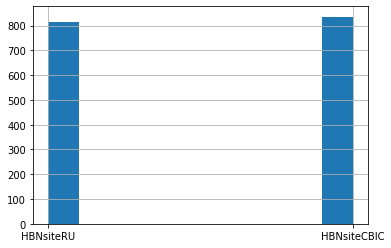

In [9]:
df_sites["sessionID"].hist()

In [11]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   target_transform_func=None,
                   target_transform_inverse_func=None,
                   n_estimators=10):
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)
    
    groups_trim = [grp for grp in groups]
    X_trim = np.copy(X)
        
    cv = RepeatedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    
    pipe_skopt = afqi.pipeline.make_base_afq_pipeline(
        imputer_kwargs={"strategy": "median"},
        power_transformer=power_transformer,
        scaler="standard",
        estimator=ElasticNetCV,
        estimator_kwargs={
            "verbose": 0,
            "n_alphas": 50,
            "l1_ratio": np.linspace(0.01, 1, 10),
            "cv": 3,
            "n_jobs": 28,
            "max_iter": 500,
        },
        verbose=0,
        ensemble_meta_estimator=ensembler,
        ensemble_meta_estimator_kwargs={
            "n_estimators": n_estimators,
            "n_jobs": 1,
            "oob_score": True,
            "random_state": 1729,
        },
        target_transform_func=target_transform_func,
        target_transform_inverse_func=target_transform_inverse_func,
    )

    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X_trim, y_fit)):
        start = datetime.now()

        X_train, X_test = X_trim[train_idx], X_trim[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]
        sites_train, sites_test = sites[train_idx].reshape(-1, 1), sites[test_idx].reshape(-1, 1)

        imputer = SimpleImputer(strategy="median")
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        combat = CombatModel()
        X_train = combat.fit_transform(X_train_imputed, sites_train)
        X_test = combat.transform(X_test_imputed, sites_test)
        
        pipe_skopt.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe_skopt,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_pred": pipe_skopt.predict(X_test),
            "y_true": y_test,
            "test_mae": median_absolute_error(y_test, pipe_skopt.predict(X_test)),
            "train_mae": median_absolute_error(y_train, pipe_skopt.predict(X_train)),
            "test_r2": r2_score(y_test, pipe_skopt.predict(X_test)),
            "train_r2": r2_score(y_train, pipe_skopt.predict(X_train)),
        }
        
        if ensembler is None:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["coefs"] = pipe_skopt.named_steps["estimate"].regressor_.coef_
                cv_results[cv_idx]["alpha"] = pipe_skopt.named_steps["estimate"].regressor_.alpha_
                cv_results[cv_idx]["l1_ratio"] = pipe_skopt.named_steps["estimate"].regressor_.l1_ratio_
            else:
                cv_results[cv_idx]["coefs"] = pipe_skopt.named_steps["estimate"].coef_
                cv_results[cv_idx]["alpha"] = pipe_skopt.named_steps["estimate"].alpha_
                cv_results[cv_idx]["l1_ratio"] = pipe_skopt.named_steps["estimate"].l1_ratio_
        else:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["coefs"] = [
                    est.coef_ for est
                    in pipe_skopt.named_steps["estimate"].regressor_.estimators_
                ]
                cv_results[cv_idx]["alpha"] = [
                    est.alpha_ for est
                    in pipe_skopt.named_steps["estimate"].regressor_.estimators_
                ]
                cv_results[cv_idx]["l1_ratio"] = [
                    est.l1_ratio_ for est
                    in pipe_skopt.named_steps["estimate"].regressor_.estimators_
                ]
            else:
                cv_results[cv_idx]["coefs"] = [
                    est.coef_ for est
                    in pipe_skopt.named_steps["estimate"].estimators_
                ]
                cv_results[cv_idx]["alpha"] = [
                    est.alpha_ for est
                    in pipe_skopt.named_steps["estimate"].estimators_
                ]
                cv_results[cv_idx]["l1_ratio"] = [
                    est.l1_ratio_ for est
                    in pipe_skopt.named_steps["estimate"].estimators_
                ]

        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [12]:
results = {}

results[f"bagging_elastic_net"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=False, shuffle=False
)

results[f"bagging_target_transform_elastic_net"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=False, shuffle=False,
    target_transform_func=np.log, target_transform_inverse_func=np.exp,
)

/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6510330517889997, tolerance: 1.1077817790771134
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.020778436142791, tolerance: 1.064759217026887
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.330311339367654, tolerance: 1.1077817790771134
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

CV index [  0], Elapsed time:  0:04:09.200236


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.310347380017447, tolerance: 1.0890378095123316
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.95440542903998, tolerance: 1.0890378095123316
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.727184195899099, tolerance: 1.0726869263895082
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

CV index [  1], Elapsed time:  0:04:31.486663


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3349142763609052, tolerance: 1.0540519980768919
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4407440275672343, tolerance: 1.0943454086565083
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1321482319413008, tolerance: 1.0750230609979983
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

CV index [  2], Elapsed time:  0:03:53.114744


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1159951322797497, tolerance: 1.0930748934913403
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3767563975902704, tolerance: 1.0930748934913403
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.724582042730617, tolerance: 1.0640746228096822
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

CV index [  3], Elapsed time:  0:03:52.129088


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7694087859217689, tolerance: 1.0926381548468362
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8408683795096294, tolerance: 1.0863348007983855
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.253860575453473, tolerance: 1.0926381548468362
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

CV index [  4], Elapsed time:  0:03:53.802857


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010235839269732594, tolerance: 0.00942846540205181
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01229475257946433, tolerance: 0.009424527996314191
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017499790593564768, tolerance: 0.00942846540205181
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterat

CV index [  0], Elapsed time:  0:03:34.930192


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013922669748186678, tolerance: 0.00938373382661898
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028277246446503312, tolerance: 0.009488933035104669
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020553379697012986, tolerance: 0.00938373382661898
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

CV index [  1], Elapsed time:  0:03:50.789640


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0231182225008979, tolerance: 0.009376140762522448
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009374187522286803, tolerance: 0.009204991700804261
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011820966129707955, tolerance: 0.009350114064614818
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

CV index [  2], Elapsed time:  0:03:42.801530


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01842912677532027, tolerance: 0.009303409513576808
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01628500255143095, tolerance: 0.009511845419277591
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012358829792503911, tolerance: 0.009511845419277591
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

CV index [  3], Elapsed time:  0:03:38.403863


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012392243781029322, tolerance: 0.009499574402682646
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009583162766212183, tolerance: 0.009478935254970726
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011190587787421435, tolerance: 0.009499574402682646
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

CV index [  4], Elapsed time:  0:03:39.762134


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5779534352808469, tolerance: 0.01423343096452879
  positive)


In [16]:
results.keys()

dict_keys(['bagging_elastic_net', 'bagging_target_transform_elastic_net'])

In [17]:
for metric in ["test_mae", "test_r2", "train_mae", "train_r2"]:
    for key, res in results.items():
        mean_metric = [cvr[metric] for cvr in res[0].values()]
        print(metric, key, np.mean(mean_metric))
    
    print()

test_mae bagging_elastic_net 1.5209484150437387
test_mae bagging_target_transform_elastic_net 1.4279534937464249

test_r2 bagging_elastic_net 0.5613915553882581
test_r2 bagging_target_transform_elastic_net 0.588187691905208

train_mae bagging_elastic_net 1.3257050215029538
train_mae bagging_target_transform_elastic_net 1.2330383024223495

train_r2 bagging_elastic_net 0.6885027058826603
train_r2 bagging_target_transform_elastic_net 0.6981561262853907



In [18]:
with open("hbn_regression_elastic_net.pkl", "wb") as fp:
    pickle.dump(results, fp)